In [1]:
import torch
import torch.nn as nn
import numpy as np
import math

from datasets.openml_datasets import OpenML_Dataset
from datasets.torch_datasets import Torch_Dataset
from utils.weakener import Weakener
#from models.model import MLP
from models.general_model import MLP
from utils.losses import PartialLoss,CELoss,LBLoss
from utils.trainig_testing import train_and_evaluate,warm_up,ES_train_and_evaluate

In this case we will create 4 data structures so they contain the 4 Weak structures that support the 4 reconstruction matrices

In [2]:
rec_names = ['_pinv', '_opt', '_conv', '_optconv']
batch_size = 128
dataset_objects = []
weakener_objects = []

# Create dataset objects
for name in rec_names:
    dataset_name = 'Data' + name
    dataset = Torch_Dataset('mnist', batch_size=batch_size)
    dataset_objects.append(dataset)
    globals()[dataset_name] = dataset  # store dataset object in a variable with the corresponding name

# Create weakener objects
for name in rec_names:
    dataset_name = 'Data' + name
    weakener_name = 'Weak' + name
    weakener = Weakener(globals()[dataset_name].num_classes)
    weakener_objects.append(weakener)
    globals()[weakener_name] = weakener

In [3]:
rec_params = {'_pinv':{'optimize':False,'convex':False},
              '_opt':{'optimize':True,'convex':False},
              '_conv':{'optimize':False,'convex':True},
              '_optconv':{'optimize':True,'convex':True}}
for i,name in enumerate(rec_names):
    weakener_objects[i].generate_M('pll')
    _,train_y,_,_ =  globals()['Data'+name].get_data()
    #_,train_y,_,_ =  dataset_objects[i].get_data()
    _,_ = globals()['Weak'+name].generate_weak(train_y)
    #_,_ = weakener_objects[i].generate_weak(train_y)
    globals()['Weak'+name].virtual_matrix(convex=rec_params[name]['convex'],
                                       optimize=rec_params[name]['optimize'])
    #weakener_objects[i].virtual_matrix(convex=rec_params[name]['convex'],
    #                                   optimize=rec_params[name]['optimize'])
    globals()['Weak'+name].virtual_labels()
    #weakener_objects[i].virtual_labels()
    globals()['Data'+name].include_weak(globals()['Weak'+name].v)
    #dataset_objects[i].include_weak(weakener_objects[i].v)

In [4]:
def weight_allocation(net,weights):
    for name, param in net.named_parameters():
        w = name.split('.')
        w_name = 'fc'+str(int(w[1])+1)+'.'+w[2]
        param.data = weights[w_name]
    return net

In [5]:
#We will do the trainig for all the models
all_result = {}
all_model = {}
for i,name in enumerate(rec_names):
    trainloader, testloader = globals()['Data'+name].get_dataloader()
    mlp_feature = MLP(globals()['Data'+name].num_features,
                      [globals()['Data'+name].num_features, globals()['Data'+name].num_features, globals()['Data'+name].num_features],
                      globals()['Data'+name].num_classes, dropout_p = 0.0, bn = False, seed = 1,
                  layer_init = lambda x: nn.init.kaiming_uniform_(x, a=math.sqrt(5))
                      )
    valen_weights = torch.load('results/mnist_random')
    mlp_feature = weight_allocation(mlp_feature,valen_weights)
    optim = torch.optim.Adam(mlp_feature.parameters(),lr=1e-5)
    loss = LBLoss(k=0.5,beta=1.1)
    print('\nTraining for'+ name +'reconstruction starts:\n')
    mlp_feature, results = ES_train_and_evaluate(mlp_feature,trainloader,testloader,
                                      optimizer=optim,loss_fn=loss,num_epochs=100,patience=5)
    all_model[name] = {'model':mlp_feature,'optimizer':optim,'loss':loss}
    all_result[name] = results



Training for_pinvreconstruction starts:

Epoch 1/100: Train Loss: 45.4167, Train Acc: 0.8315, Test Acc: 0.6930
Epoch 2/100: Train Loss: 4.0486, Train Acc: 0.7056, Test Acc: 0.7338
Epoch 3/100: Train Loss: 3.4038, Train Acc: 0.7506, Test Acc: 0.7812
Epoch 4/100: Train Loss: 3.1109, Train Acc: 0.7931, Test Acc: 0.8107
Epoch 5/100: Train Loss: 2.9360, Train Acc: 0.8222, Test Acc: 0.8351
Epoch 6/100: Train Loss: 2.8142, Train Acc: 0.8422, Test Acc: 0.8592
Epoch 7/100: Train Loss: 2.7225, Train Acc: 0.8608, Test Acc: 0.8714
Epoch 8/100: Train Loss: 2.6497, Train Acc: 0.8722, Test Acc: 0.8840
Epoch 9/100: Train Loss: 2.5893, Train Acc: 0.8829, Test Acc: 0.8919
Epoch 10/100: Train Loss: 2.5415, Train Acc: 0.8921, Test Acc: 0.8983
Epoch 11/100: Train Loss: 2.4988, Train Acc: 0.8988, Test Acc: 0.9042
Epoch 12/100: Train Loss: 2.4635, Train Acc: 0.9060, Test Acc: 0.9132
Epoch 13/100: Train Loss: 2.4311, Train Acc: 0.9111, Test Acc: 0.9133
Epoch 14/100: Train Loss: 2.4053, Train Acc: 0.9150, Tes

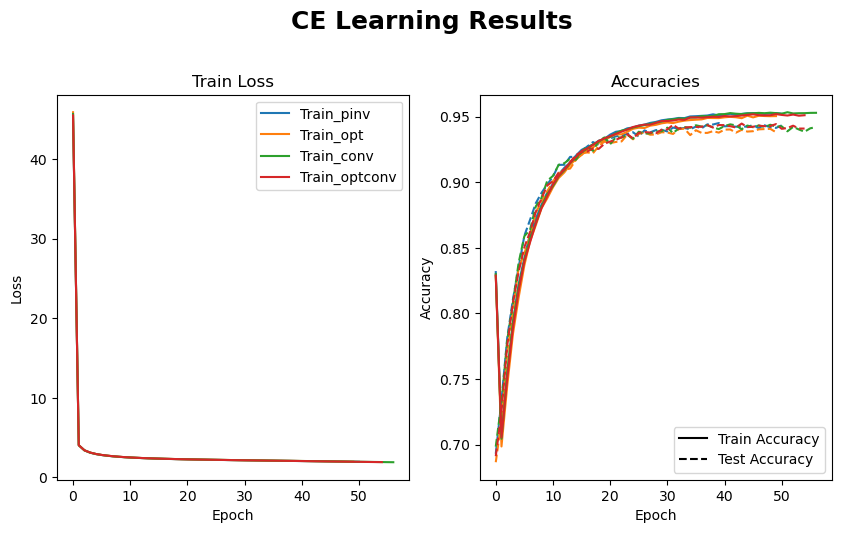

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

tableau_palette = mcolors.TABLEAU_COLORS

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
colors = list(tableau_palette.values())

# Plot the first subplot (Train Loss)
for i,name in enumerate(rec_names):
    ax1.plot(all_result[name]['train_loss'],label='Train'+name,color=colors[i])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Train Loss')


# Plot the second subplot (Accuracies)
for i,name in enumerate(rec_names):
    ax2.plot(all_result[name]['train_acc'], label='Train Accuracy'+name,
             color=colors[i])
    ax2.plot(all_result[name]['test_acc'], label='Test Accuracy'+name,
             color=colors[i],linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracies')
#ax2.legend()
legend_elements = [Line2D([0], [0], linestyle='-', color='black', label='Train Accuracy'),
                   Line2D([0], [0], linestyle='--', color='black', label='Test Accuracy')]
ax2.legend(handles=legend_elements)

fig.suptitle('CE Learning Results', fontsize=18, fontweight='bold', y=1.05)
# Show the plot
plt.show()

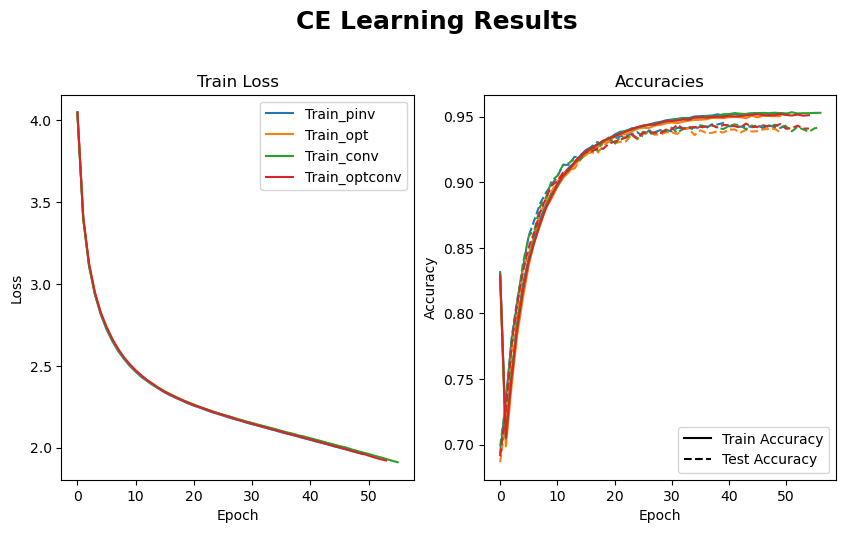

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

tableau_palette = mcolors.TABLEAU_COLORS

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
colors = list(tableau_palette.values())

# Plot the first subplot (Train Loss)
for i,name in enumerate(rec_names):
    ax1.plot(all_result[name]['train_loss'][1:],label='Train'+name,color=colors[i])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Train Loss')


# Plot the second subplot (Accuracies)
for i,name in enumerate(rec_names):
    ax2.plot(all_result[name]['train_acc'], label='Train Accuracy'+name,
             color=colors[i])
    ax2.plot(all_result[name]['test_acc'], label='Test Accuracy'+name,
             color=colors[i],linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracies')
#ax2.legend()
legend_elements = [Line2D([0], [0], linestyle='-', color='black', label='Train Accuracy'),
                   Line2D([0], [0], linestyle='--', color='black', label='Test Accuracy')]
ax2.legend(handles=legend_elements)

fig.suptitle('CE Learning Results', fontsize=18, fontweight='bold', y=1.05)
# Show the plot
plt.show()